In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections

import matplotlib.dates as mdates
import datetime

from jhu_data import DEATHS_CSV, CONFIRMED_CSV, DataSeries, exponent_timeseries
from plotting import COUNTRY_COLOR, LOCKDOWN_DATES


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
deaths_csv = pd.read_csv(DEATHS_CSV)
confirmed_csv = pd.read_csv(CONFIRMED_CSV)

In [3]:
def plot_cases_deaths(country):
    color = COUNTRY_COLOR[country]
    deaths = DataSeries(deaths_csv, country=country)
    confirmed = DataSeries(confirmed_csv, country=country)
    fit_deaths = deaths.fit(cutoff=10, slicing=slice(-10, None))
    fit_confirmed = confirmed.fit(cutoff=100, slicing=slice(-10, None))
    deaths_cutoff = deaths.data(cutoff=10)
    fig, ax = plt.subplots()
    confirmed_cutoff = confirmed.data(cutoff=100)
    ax.plot(confirmed_cutoff, color=color, label="Cases")
    ax.plot(confirmed_cutoff.index, fit_confirmed.extrapolate(0, len(confirmed_cutoff)), '--', color=color)
    ax.plot(deaths_cutoff, '-.', color=color, label="Deaths")
    ax.plot(deaths_cutoff.index, fit_deaths.extrapolate(0, len(deaths_cutoff)), ':', color=color)
    fig.autofmt_xdate()
    plt.legend()
    plt.yscale('log')

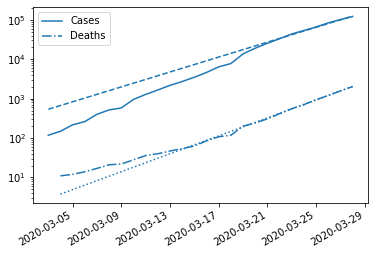

In [4]:
plot_cases_deaths("US")

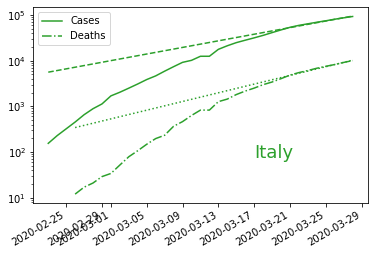

In [5]:
plot_cases_deaths("Italy")
plt.text(mdates.date2num(datetime.date(2020, 3, 17)), 75, "Italy", fontdict={'size': 18, 'color': "C2"});
plt.savefig("cases_deaths_italy.svg")

In a previous post, I described how to read these semi-log plots. To review, you see a curve for the data (here, solid for total confirmed cases and dot-dashed for total deaths) and a straight line (dashed for cases, dotted for deaths) that represents an extrapolation from the last few days (in this case, the last 10). What we want to see is that the actual data lies below the extrapolated line; that indicates that things are getting better. Eventually, we want that extrapolation be perfectly horizontal. As we can see with the data for Italy above, things are getting better in Italy. Both the confirmed cases and deaths are not increasing as quickly as they used to.

In this post, I'll look at how the slope of that line is changing in over time for several countries. In Italy, it is getting more horizontal (smaller slope), which is what we want to see. One of the general challenges with comparing the response to outbreaks in different countries is that it can be difficult to 

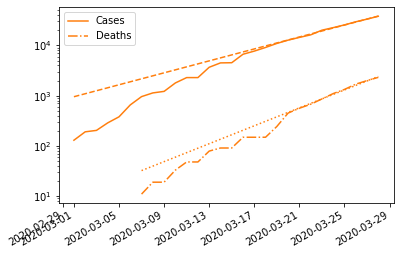

In [6]:
plot_cases_deaths("France")

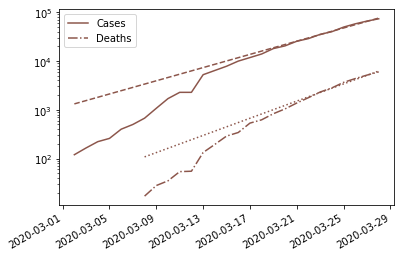

In [7]:
plot_cases_deaths("Spain")

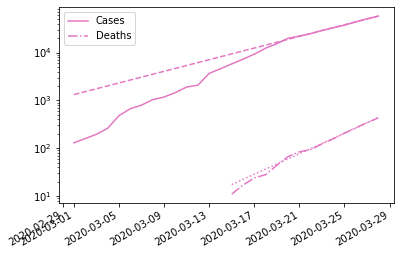

In [8]:
plot_cases_deaths("Germany")

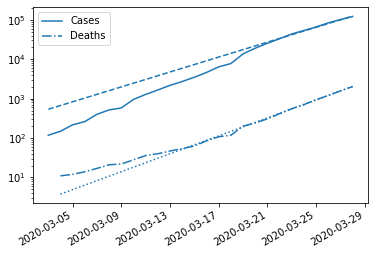

In [9]:
plot_cases_deaths("US")

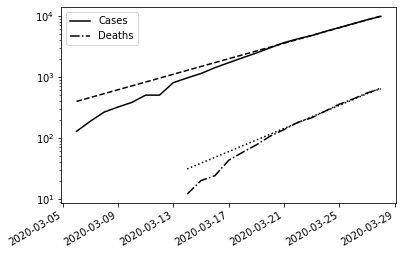

In [10]:
plot_cases_deaths("Netherlands")

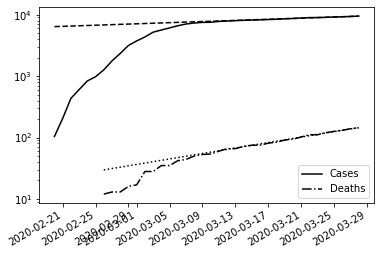

In [11]:
plot_cases_deaths("Korea, South")

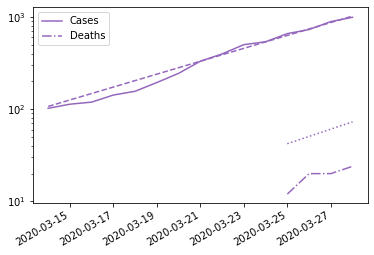

In [12]:
plot_cases_deaths("India")

In [13]:
def plot_exponents(country, ax, interval=5, data_type="cases"):
    color = COUNTRY_COLOR[country]
    csv = {"cases": confirmed_csv, "deaths": deaths_csv}[data_type]
    cutoff = {"cases": 100, "deaths": 10}[data_type]
    series = DataSeries(csv, country=country)
    if country == "China":
        # only use first 45 days of China info; gets noisy after
        series._data = series._data[:45]
    ax.plot(exponent_timeseries(series, cutoff=cutoff, interval=interval), color=color,
            label=country)
    for date in LOCKDOWN_DATES[country]:
        ax.axvline(x=mdates.date2num(date), linestyle='-', linewidth=0.5, color=color)

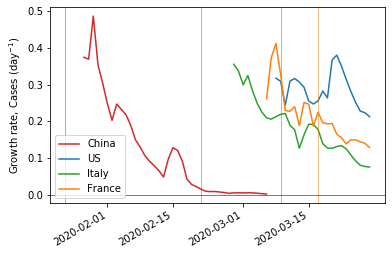

In [14]:
fig, ax = plt.subplots()
plot_exponents("China", ax)
plot_exponents("US", ax)
plot_exponents("Italy", ax)
plot_exponents("France", ax)
#plot_exponents("Spain", ax)
ax.axhline(y=0.0, linestyle='-', linewidth=0.5, color='k')
plt.ylabel("Growth rate, Cases (day$^{-1}$)")
plt.legend();
fig.autofmt_xdate()
plt.savefig("exponents_cases.svg")

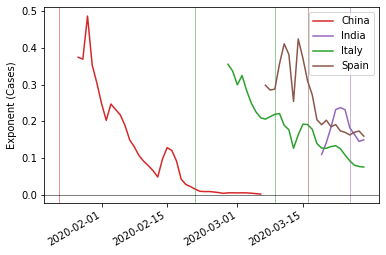

In [15]:
fig, ax = plt.subplots()
plot_exponents("China", ax)
plot_exponents("India", ax)
plot_exponents("Italy", ax)
plot_exponents("Spain", ax)
ax.axhline(y=0.0, linestyle='-', linewidth=0.5, color='k')
plt.ylabel("Exponent (Cases)")
plt.legend();
fig.autofmt_xdate()

## What are we measuring?

The thing we're measuring is an estimate of the rate constant for the process, assuming (local) exponential kinetics. This is closely related to the inverse (reciprocal) of the doubling time. That is, if the rate goes down, the doubling time gets longer. (Mathematically, the rate $k$ and doubling time $t_d$ are related as $t_d = \ln(2) / k \approx 0.693 / k$.) A low rate (and long doubling time) are what you want to see.

I won't refer to it as a rate in the following, though, because people are likely to confuse "rate" with things like "mortality rate", which is very different. I'll call this "the exponent" because it comes from fitting the exponent in the function $f(t) = e^{-k t}$, where $t$ is time.

## Time evolution of fitted exponents

In this plot, I plot the exponents for total confirmed cases for several countries as a function of date. The thin vertical lines represent the start dates of lockdowns; for China, that is the Hubei province lockdown; for Italy, the earlier date is the lockdown in northern Italy and the later date is the national lockdown; and for France it is the national lockdown.

The goal is to reduce the exponent to zero. The data shown here starts after the country has 100 cases. China quickly reduced its exponent to zero. Italy has been steadily decreasing. France stabilized around a value of 0.2 for a while before establishing a national lockdown, and has been decreasing ever since. In the 3 weeks since the US reached 100 confirmed cases, its exponent has not changed significantly, although it may be starting to show a decrease.

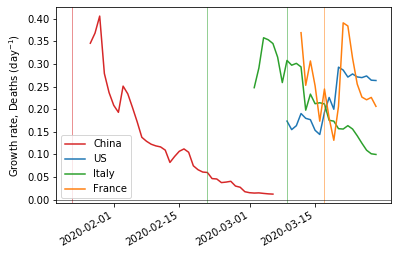

In [16]:
interval = 5
fig, ax = plt.subplots()
plot_exponents("China", ax, data_type='deaths', interval=interval)
plot_exponents("US", ax, data_type='deaths', interval=interval)
plot_exponents("Italy", ax, data_type='deaths', interval=interval)
plot_exponents("France", ax, data_type='deaths', interval=interval)
ax.axhline(y=0.0, linestyle='-', linewidth=0.5, color='k')
plt.legend();
plt.ylabel("Growth rate, Deaths (day$^{-1}$)")
fig.autofmt_xdate()
plt.savefig("exponents_deaths.svg")

We can look at the same data for deaths. Here, China and Italy tell the same story as for confirmed cases. However, France and the US are different. France's death rate has been a bit all over, I believe that this is at least in part because the data set that I use doesn't have update for France for every day, so it looks like there are no new deaths and then a bunch of new deaths. In any case, France has not decreased its rate of increase in deaths by anywhere near as much as it has decreased its rate of increase in confirmed cases. Deaths are continuing to grow as fast as before, but confirmed cases are dropping. This could indicate a significant drop in testing or an overwhelmed health care system.

As I discussed in a previous post, the rate of increase in deaths in the US has actually increased. My best guess is that this is a result of community infection taking hold. The may be a slight downward trend in recent days, but nothing comparable to the reductions seen in China or Italy.

A final point that is worth mentioning: note that, at least in these countries, the exponents near the beginning of the outbreak tend to be in the 0.2-0.4 range. This indicates that this exponent may be a reasonable tool for comparing the response of different countries to this pandemic. In addition, we see that the exponents are of similar magnitude for both confirmed cases and for deaths, which suggests that it isn't a metric that depends on the fraction of actual cases being tested. I'll explore some of these ideas further in future posts.

## Technical details

The plots are based fitting the exponent with a nonlinear fit based on the 5 days including and prior to the date associated with the value. This procedure gives poorly defined results when the number of new daily deaths is zero; therefore only the first 45 days of data for China were used. Data for deaths are only counted starting from the 10th death; data for confirmed cases are only counted starting from the 100th confirmed case.

(cite JHU data set; link to PR)